Connected to TIGON (Python 3.10.16)

In [3]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys
import scanpy as sc
import EchoSig
import EchoSig.TIGON2
import EchoSig.TIGON2.trainer
import EchoSig.utility
import random
from EchoSig.utility import retrieval_data,read_config_file,get_configs,get_traj_data,get_dataset_config
import networkx as nx
import scvelo as scv

We load input generated by dynamic module and CCC module.

In [ ]:
## read data: adata, embedding, trajectory, ect.
dataset='iPSC'
config,_,time_scale,time_unit,n_fates,num_sample,_,_,time_float,lag_list,max_lag, source_id_lst,target_id_lst = get_configs(dataset)
save_CCC_dir=config['save_dir']+'/CCC/'
z,z_original,z_original_norm,vel,vel_original,fate_idx,z_fate,J_vx_x,dg,pathway_list,gene_list,time_GRN,time,cell_name = get_traj_data(save_CCC_dir)
adata,data_train,X,embedding,_,model_ae,func,sigma,device,n_genes= retrieval_data(config)
fig_save_dir,fate_list,FDR,species,stat_test_map, cellchat,signal_type_map = get_dataset_config(dataset)
cell_list_all=[0,1]
cell_pairs = [(0,0),(0,1),(1,0),(1,1)]
percentile=95
def get_cell_pair_name(cell_pair,cell_name):    
    if cell_name is not None:
        cell_pair_str = cell_name[cell_pair[0]]+'-'+cell_name[cell_pair[1]]
    else:
        cell_pair_str = str(cell_pair[0])+'-'+str(cell_pair[1])
    return cell_pair_str

First, we visualize the velocity field and the two distinct trajectories for endoderm and mesoderm.

computing velocity graph (using 32/128 cores)


    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_ae', embedded velocity vectors (adata.obsm)


/home/yuchi/anaconda3/envs/TIGON/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/home/yuchi/anaconda3/envs/TIGON/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


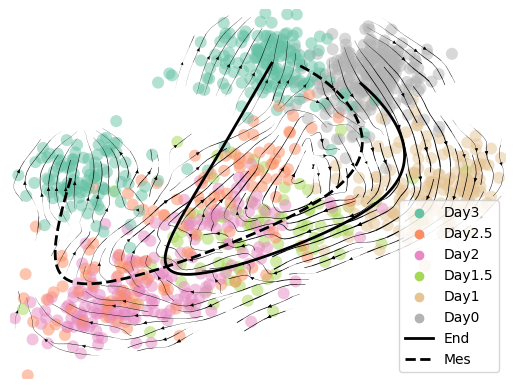

In [6]:
# Plot trajectories
Time = adata.obs['Time'].values
time_str = config['Time']['str'] 
time_map = {time_str[i]:time_float[i] for i in range(len(time_float))}
Time_float = [time_map[Time[i]] for i in range(len(Time))]
# adata.obs['Time'] = pd.Categorical(adata.obs['Time'], categories=time_str, ordered=True)

# calculate growth and velocity
g_pointwise = EchoSig.TIGON2.generate.get_g(model_ae,func,embedding,Time_float,dt=0.1)
_,_,vel_pointwise = EchoSig.TIGON2.generate.get_v(model_ae,func,embedding,Time_float,dt=0.1)

# plot velocity stream
adata.layers['velocity']=vel_pointwise
adata.layers['Ms']=adata.X
basis='ae'
scv.tl.velocity_graph(adata,vkey='velocity',n_jobs=32)

fig, ax = plt.subplots()
scv.pl.velocity_embedding_stream(adata, basis=basis,vkey='velocity',legend_loc='none',#'right margin',
                                    color='Time',title='',
                                    linewidth=0.5,
                                    arrow_size=0.5,
                                    size=300,
                                    alpha=0.5,
                                    palette='Set2',
                                    ax=ax,show=False)

# plot trajectories
linestyle = ['-','--']
for i in range(z_fate.shape[0]):
    ax.plot(z_fate[i, :, 0], z_fate[i, :, 1], 
            linewidth=2,color='black',linestyle=linestyle[i],label=fate_list[i])
ax.legend()

We visualize CCC result in a dot plot showing both causal strength and SPT for each CCC triplet in each pair.

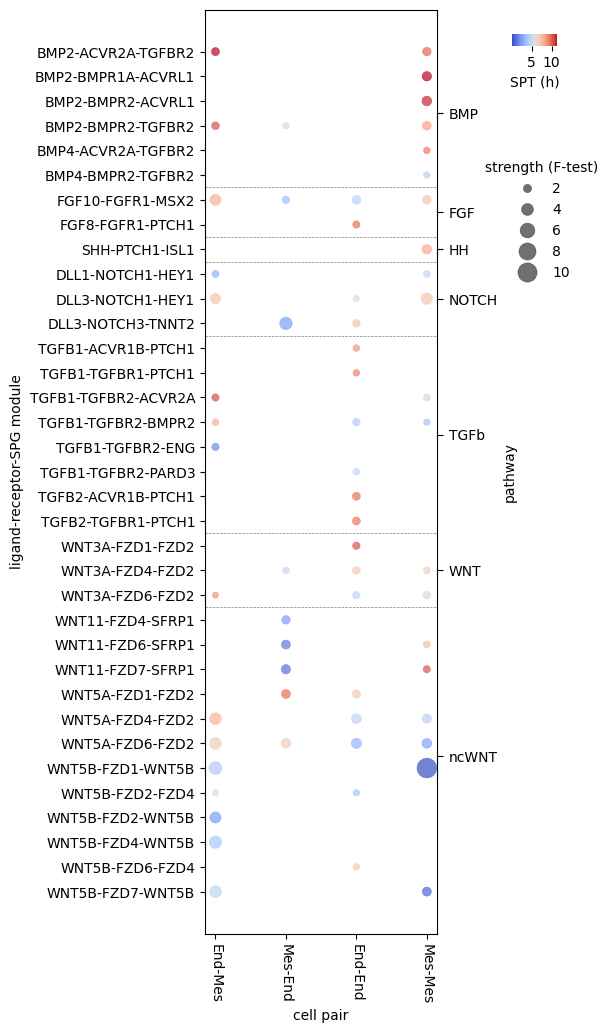

In [7]:
# Dot plots for CCC triplets 
grapher = EchoSig.pl.DotsPlots_L_R_SPG(cell_name=cell_name)
for cell_pair_idx in range(len(source_id_lst)):
    source_id = source_id_lst[cell_pair_idx]
    target_id = target_id_lst[cell_pair_idx]     
    df_CCC = pd.read_csv(save_CCC_dir+'/'+str(source_id)+'to'+str(target_id)+'/'+'results.csv',
                    index_col=0)
    grapher.add_CCC_data(df_CCC,(source_id,target_id),
                        pathway=pathway_list,FDR=FDR,)
fig, ax = plt.subplots(figsize=(3, 12)) 
_, df1=grapher.draw_LRSPG_dots(ax=ax,color_map='coolwarm',cell_pair_order=['0-1','1-0','0-0','1-1'],time_scale=1,time_unit='h')

We aggregate CCC triplets to each signaling pathway, and visualize signaling flows across cells.

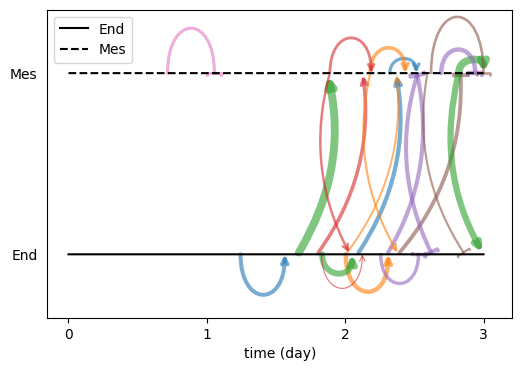

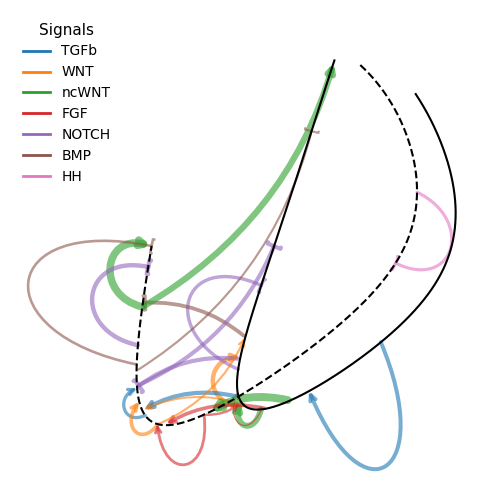

In [ ]:
# genereat temporal signaling flows plot
palette = list(sns.color_palette('tab10')\
                + sns.color_palette("Set3") \
                + sns.color_palette("Set1")\
                + sns.color_palette("Set2")\
                + sns.color_palette('Pastel1')\
                + sns.color_palette('Pastel2'))
data_signal={}
color_id=0
palette_map={}
for cell_pair in cell_pairs:
    data_signal[cell_pair]={}
    cell_pair_str = get_cell_pair_name(cell_pair,cell_name)
    target_gene=None
    grapher = EchoSig.pl.Hierarchy_L_R_SPG_SDG(cell_list_all=cell_list_all)
    source_id=cell_pair[0]
    target_id=cell_pair[1]
    ## aggreate CCC triplets for each pathway
    for path in pathway_list:
        df_CCC = pd.read_csv(save_CCC_dir+'/'+str(source_id)+'to'+str(target_id)+'/'+'results.csv',
                        index_col=0)
        grapher.add_CCC_data(df_CCC,(source_id,target_id),
                            pathway=[path],FDR=FDR)
        if len(grapher.CCC_data[cell_pair])>0:
            L_list=grapher.CCC_data[cell_pair]['L'].values
            Ligands = np.mean(z_original_norm[fate_idx[source_id],:,:],axis=0)[:,[gene_list.index(l) for l in L_list]]
            L=np.mean(Ligands,axis=1)

            lag=np.mean(grapher.CCC_data[cell_pair]['lag'].values)
            strength = np.sum(grapher.CCC_data[cell_pair]['stat '+grapher.test])
            max_signal_time = time[np.argmax(L)] 
            x_start = max_signal_time
            x_end = max_signal_time + lag
            if x_end>time[-1]:
                x_end=time[-1]
                x_start=x_end-lag
            data_signal[cell_pair][path]=np.array([x_start,x_end,strength])

            if not path in palette_map.keys():

                color=palette[color_id]
                palette_map[path]=color
                color_id+=1


linecolor = 'black'
linestyle = ['-','--']
direct_dic = {(0,0):'in',(1,1):'out'}

## signaling flows at time axis (horizontal trajectories)
traj_lines = np.array([np.array([time, fate_id * np.ones(time.shape)]).T
                        for fate_id in range(len(fate_list))])
ax,G = EchoSig.pl.temporal_talks(data_signal,
            traj_lines,
            fate_list,
            time,
            palette_map,
            height=0.005,
            min_height=0.0,
            width_scale=4,
            direct_dic=direct_dic,
            linecolor=linecolor,
            linestyle=linestyle,
            figsize=(6,4),
            )
ax.tick_params(bottom=True,labelleft=True, labelbottom=True)
xticks = [0,24,48,72]
ax.set_xticks(xticks)
ax.set_xticklabels([str(x // 24) for x in xticks])
ax.set_xlabel('time (day)')
ax.set_ylim([-0.35,1.35])
ax.set_yticks([0,1])
ax.set_yticklabels(fate_list)
ax.legend()

## signaling flows at embedding space (curved trajectories)
ax,G = EchoSig.pl.temporal_talks(data_signal,z_fate,fate_list,time,palette_map,
            height=2.,
            min_height=1,
            width_scale=4,
            linecolor=linecolor,
            linestyle=linestyle,)
ax.legend()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.set_xlim([-2.8,1.3])
ax.set_ylim([-1.6,1.6])
from matplotlib.lines import Line2D
palette_map_clean = {str(k): v for k, v in palette_map.items()}
legend_handles = [
    Line2D([0], [0], color=color, linewidth=2, label=label)
    for label, color in palette_map_clean.items()
]
ax.legend(
    handles=legend_handles,
    title="Signals",
    frameon=False,
    fontsize=10,
    title_fontsize=11
)

Generate relay network for pathway-pathway interaction across cells

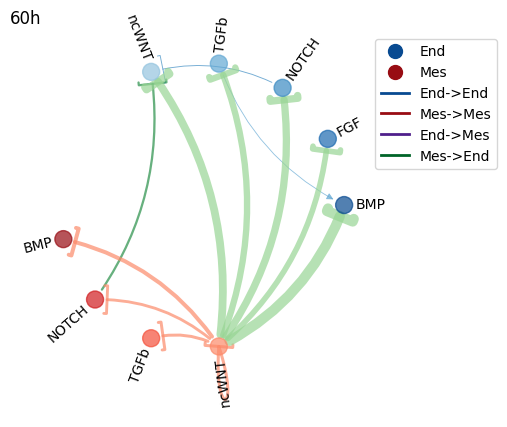

In [ ]:
# Generate signaling relay network
net = ['pathway','pathway']
pathway_list=None 
time_idx=60

grapher = EchoSig.pl.Circle_L_L(net=net,cell_name=cell_name)
for cell_pair_idx in range(len(source_id_lst)):
    source_id = source_id_lst[cell_pair_idx]
    target_id = target_id_lst[cell_pair_idx]     
    df_CCC = pd.read_csv(save_CCC_dir+'/'+str(source_id)+'to'+str(target_id)+'/'+'results.csv',
                    index_col=0)
    grapher.add_CCC_data(df_CCC,(source_id,target_id),pathway=pathway_list,FDR=FDR)
grapher.get_node_list()
for cell_id in range(len(fate_idx)):
    grapher.add_GRN(J_vx_x,
                    time=time_GRN,
                    time_idx=time_idx,
                    cell_id=cell_id,
                    fate_idx=fate_idx,
                    gene_list=gene_list,
                    percentile=percentile)

fig, ax = plt.subplots(figsize=(5, 5))
grapher.create_G(time_scale=1,time_unit='h')
grapher.draw_G(ax=ax,
            width_scale=0.05,
            palette={0:'Blues_r',1:'Reds_r'},
            palette_edge_dic={(0,1):'Purples_r',(1,0):'Greens_r'},
                                )
ax.set_title(f'{time_GRN[time_idx]:.0f}'+time_unit, loc='left')
fig.canvas.draw()

plt.show()    


Generate hierarchical network for selected pathway, cell pair, and time point.

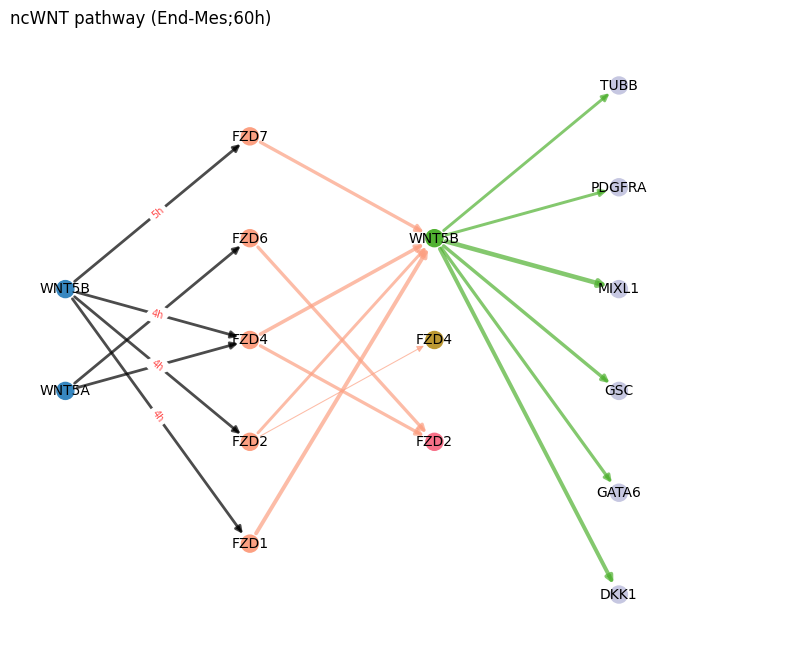

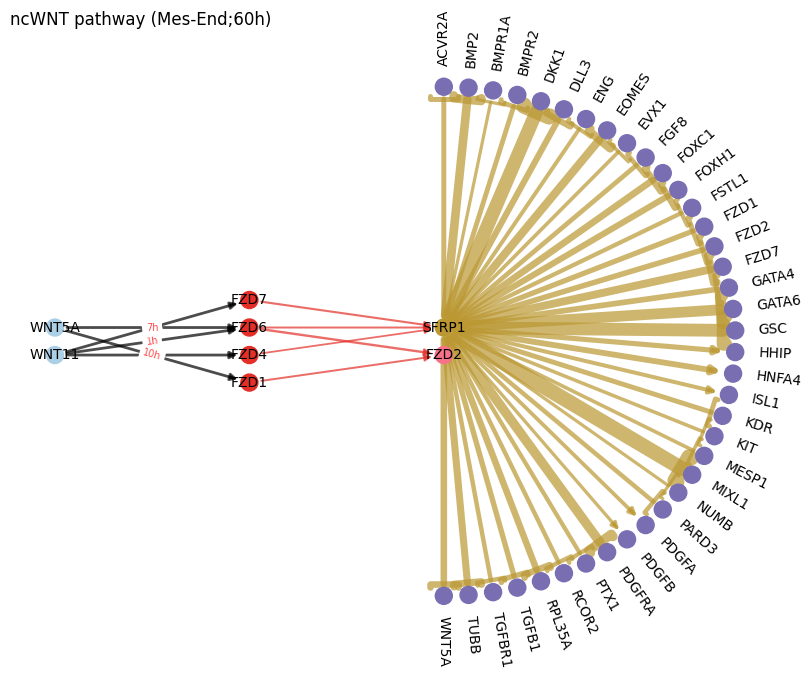

In [11]:
# Generarte hierarchical signaling networks
pathway='ncWNT'
time_idx=60
for cell_pair in [(0,1),(1,0)]:
    grapher = EchoSig.pl.Hierarchy_L_R_SPG_SDG(cell_list_all=cell_list_all)
    source_id=cell_pair[0]
    target_id=cell_pair[1]
    df_CCC = pd.read_csv(save_CCC_dir+'/'+str(source_id)+'to'+str(target_id)+'/'+'results.csv',
                    index_col=0)
    grapher.add_CCC_data(df_CCC,(source_id,target_id),
                        pathway=pathway,FDR=FDR)
    grapher.get_node_list()
    grapher.add_GRN(J_vx_x,
                    time=time,
                    time_GRN=time_GRN,
                    time_idx=time_idx,
                    cell_id=target_id,
                    fate_idx=fate_idx,
                    gene_list=gene_list,
                    percentile=percentile,)
    grapher.create_G(cell_pair=cell_pair)
    plt.figure(figsize=(10,8))
    result=grapher.draw_G(cell_pair=cell_pair,width_scale=0.6,width_scale_grn=.3)
    plt.title(f'{pathway} pathway ({get_cell_pair_name(cell_pair,cell_name)};{time_GRN[time_idx]:.0f}{time_unit})', loc='left')